# Import .MAT Database and create numpy arrays

In [6]:
import os

current_dir=os.getcwd()
db_path_mech=os.path.join(current_dir,'..','0. Create DB','database5SS_n5900_Mech.mat')
db_path_path=os.path.join(current_dir,'..','0. Create DB','database5SS_n5900_Path.mat')
db_path_orient=os.path.join(current_dir,'..','0. Create DB','database5SS_n5900_Orient.mat')

In [7]:
from scipy.io import loadmat
import numpy as np

matData = loadmat(db_path_mech)
MechList=matData['Mech'][0]
matData = loadmat(db_path_path)
CplrPathList=matData['CplrPath'][0]
matData = loadmat(db_path_orient)
CplrOrientList=matData['CplrOrient'][0]

print(np.array(MechList).shape)
print(np.array(CplrPathList).shape)
print(np.array(CplrOrientList).shape)

(5900,)
(5900,)
(5900,)


# Plot sample Coupler curve data

In [77]:
%run "plotting_functions.ipynb"

<IPython.core.display.Javascript object>


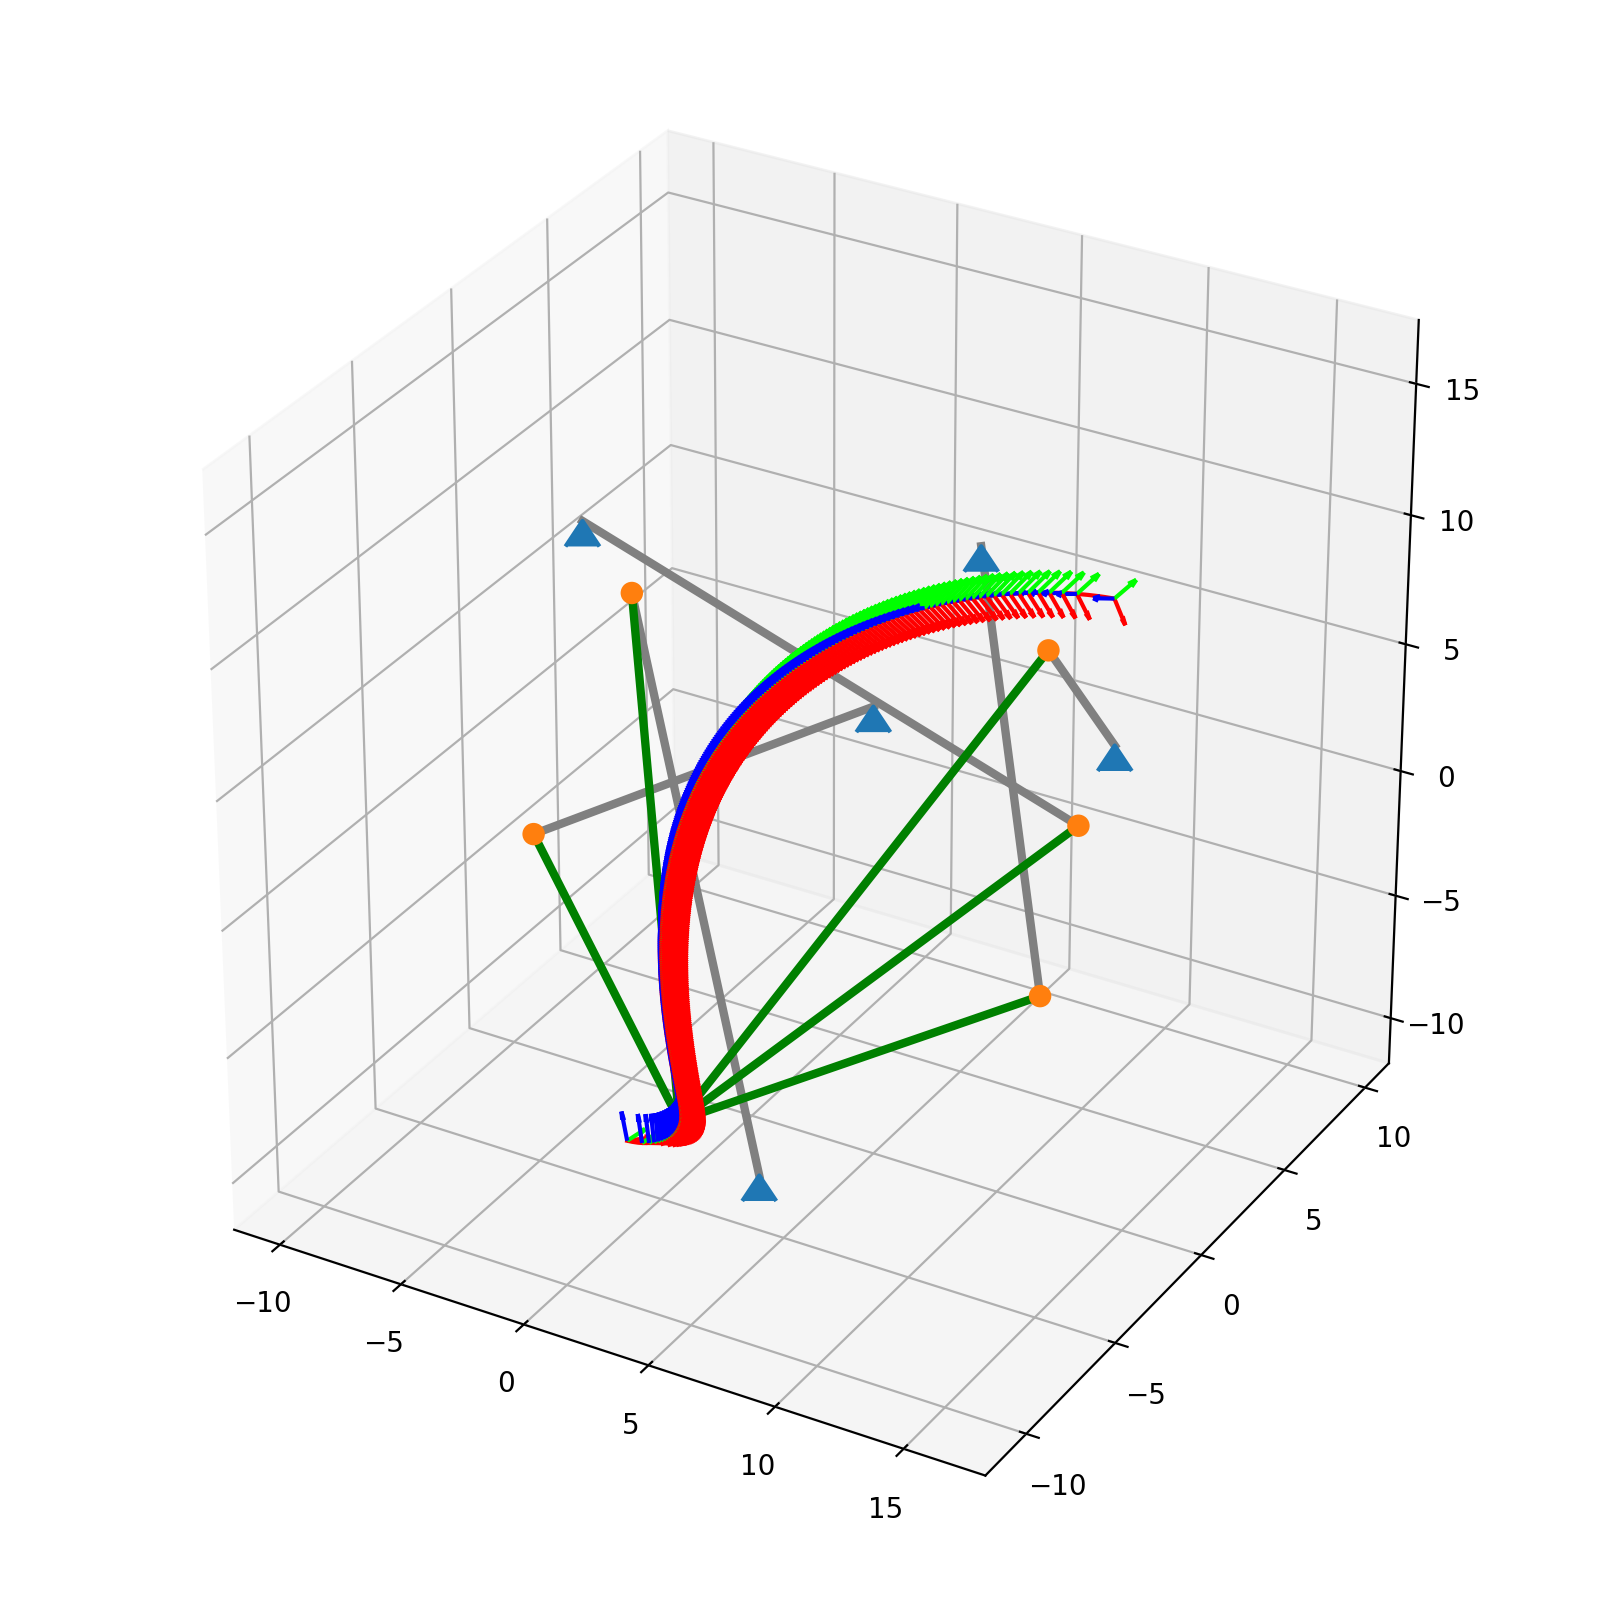

In [78]:
fig= plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection='3d')
plotMech5SS(MechList[0],ax)
#plotPath(CplrPathList[0], ax, 10,'r' )
plotMotion(CplrPathList[0],CplrOrientList[0], ax, 10,'r' )

<IPython.core.display.Javascript object>


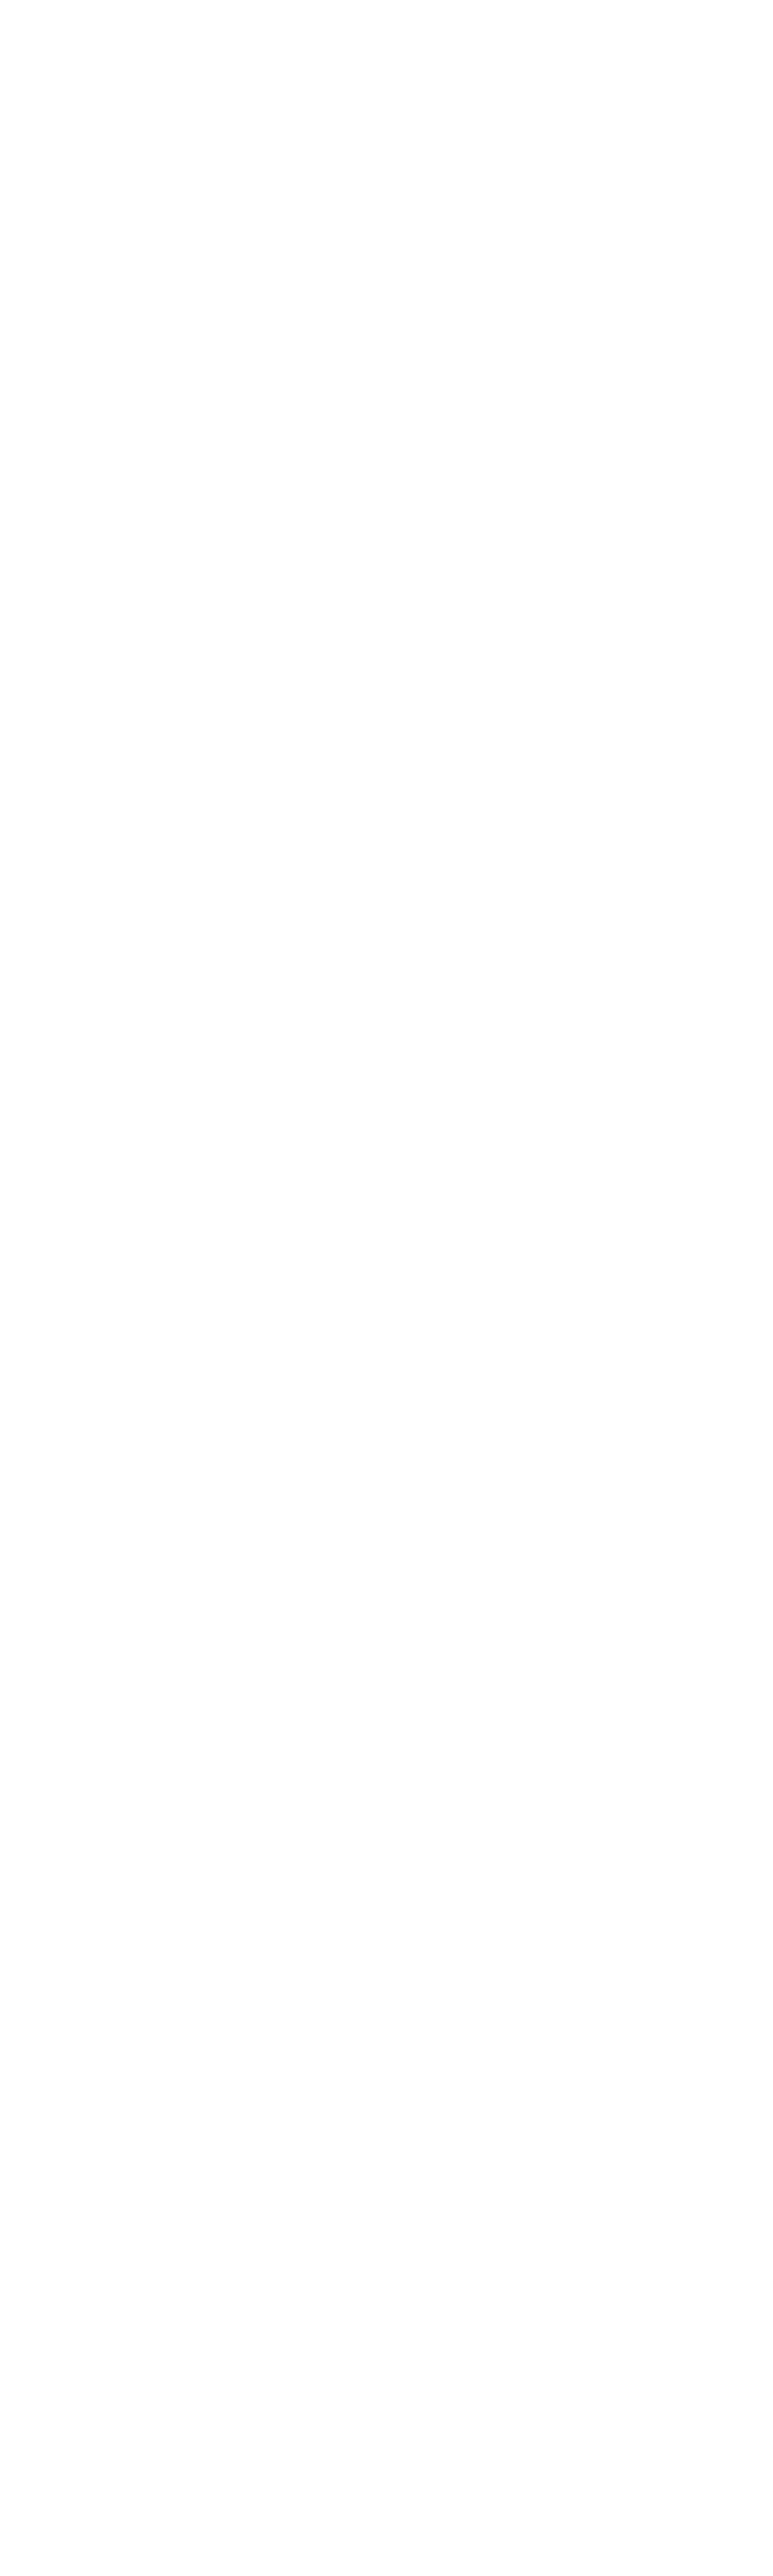

KeyboardInterrupt: 

In [36]:
#visualizePathsRand(CplrPathList,axlimit=20)
visualizeMotionsRand(CplrPathList,CplrOrientList,axlimit=20)

<IPython.core.display.Javascript object>


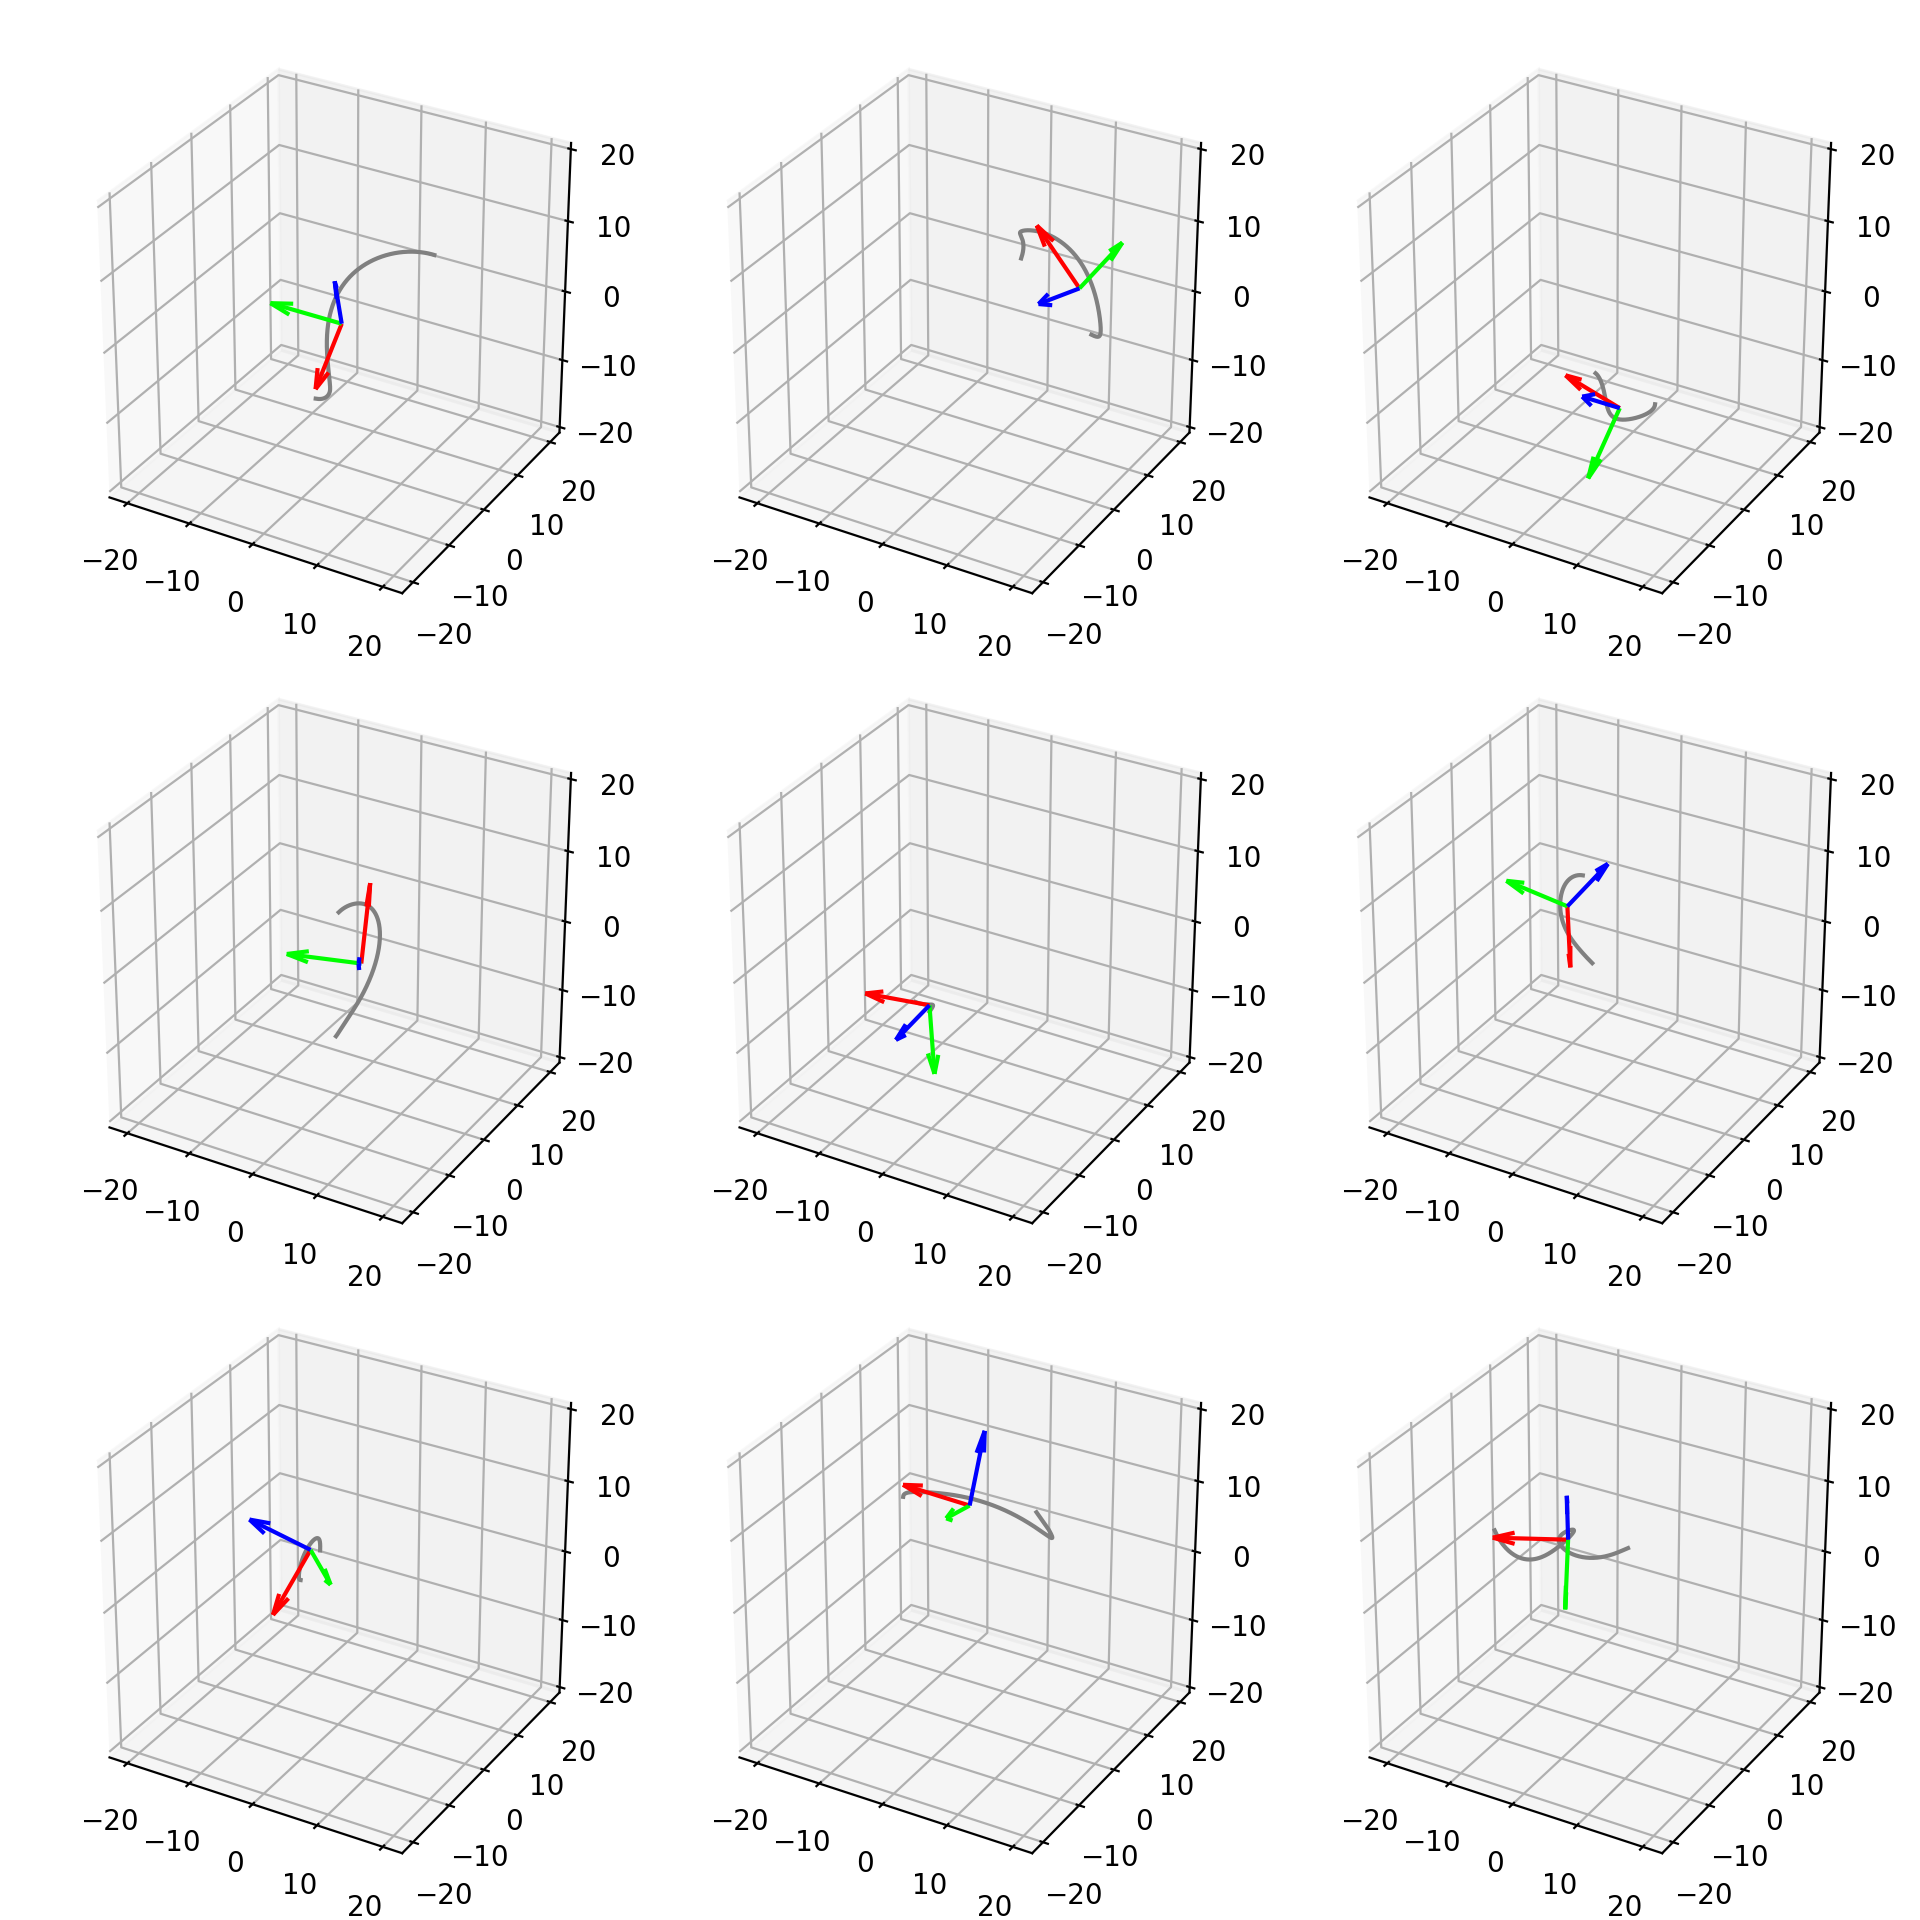

In [43]:
# Plot curve and visualize its mean and principal axes 
rows=3
cols=3

path_index=0;
fig = plt.figure(figsize=2*plt.figaspect(cols/rows))
for i in range(rows):
    for j in range(cols):
        Pts=CplrPathList[path_index]
        path_index=path_index+1
        ax = fig.add_subplot(cols, rows, path_index, projection='3d')
        plotPath(Pts, ax, 20)
        
        C=np.mean(Pts,axis=0)
        Covariance_Mat=np.cov(Pts,rowvar=0)
        sing_vec=LA.svd(Covariance_Mat)[0]
        R=sing_vec.T*10
        plotXYZ(C, R, ax)

# Remove Coupler paths with too less data

As can be seen in the histogram, the number of points in each coupler path ranges from 2 to 3126 points. We ignore paths having less than 10 datapoints

<IPython.core.display.Javascript object>


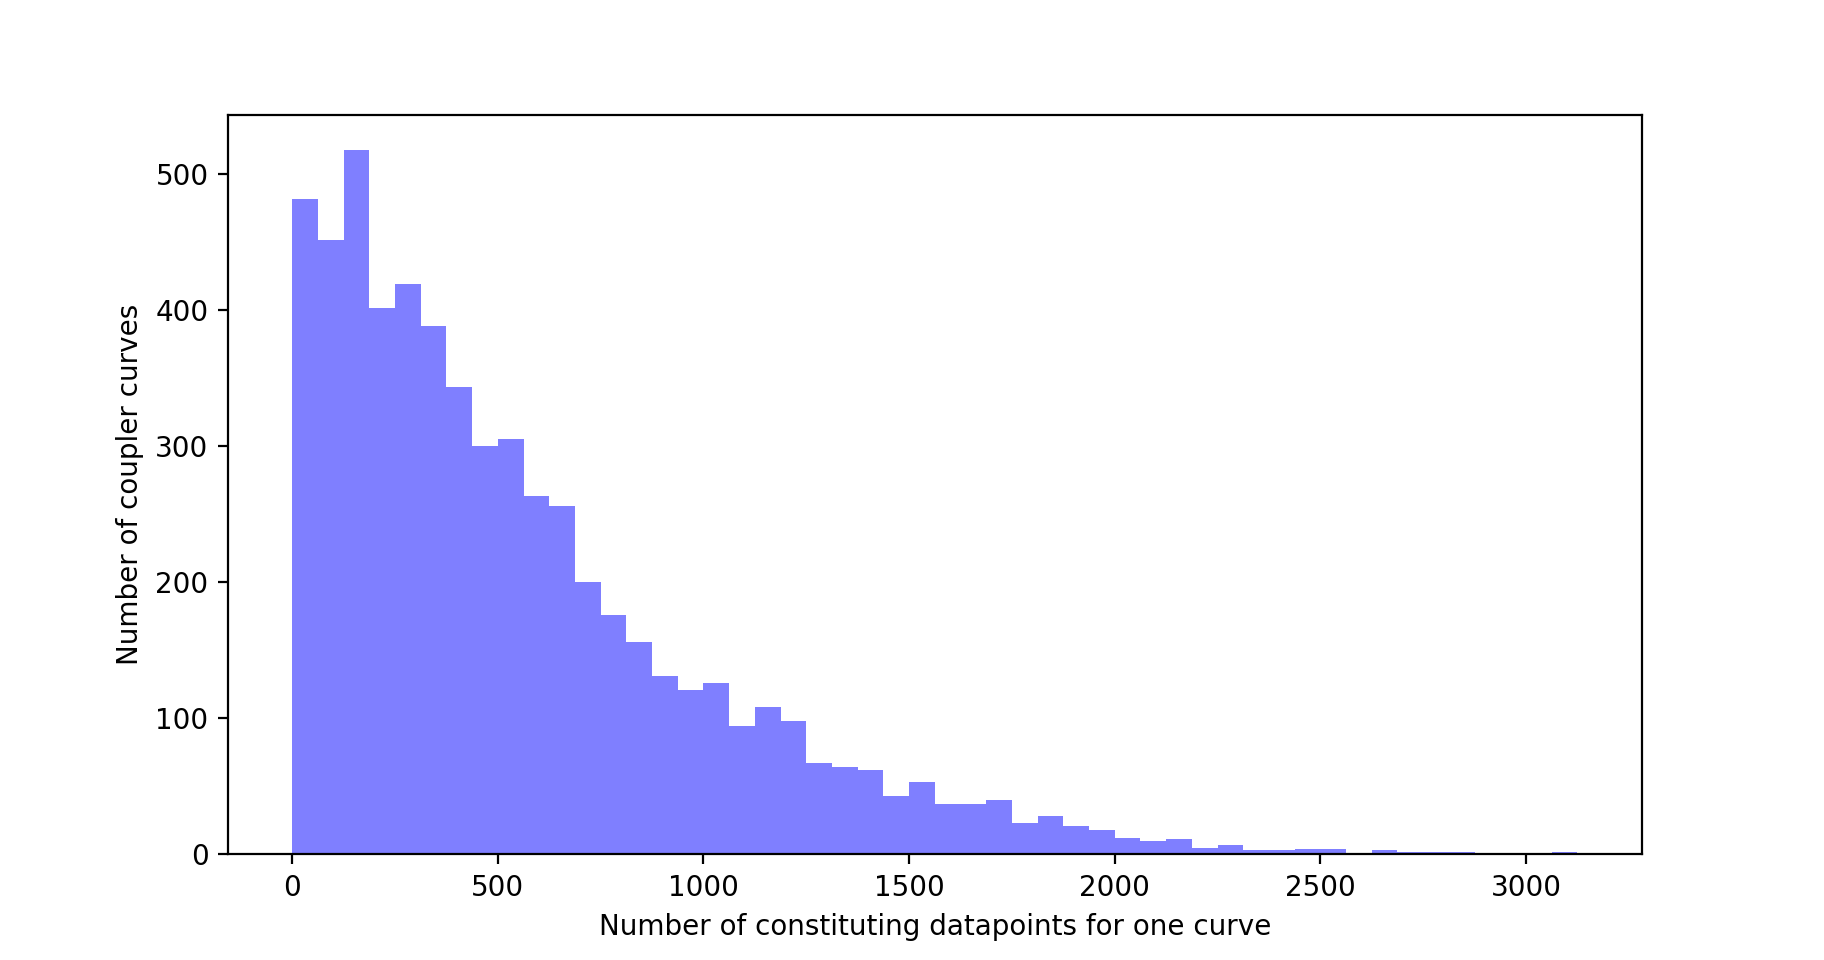

The minimum number of points in a coupler curve are: 1
The maximum number of points in a coupler curve are: 3125


In [37]:
no_Path_Pts=[];
for i in range(len(CplrPathList)):
    no_Path_Pts.append(CplrPathList[i].shape[0])

fig = plt.figure(figsize=1*plt.figaspect(1/1.9))
n, bins, patches = plt.hist(no_Path_Pts, 50, facecolor='blue', alpha=0.5)
plt.xlabel('Number of constituting datapoints for one curve')
plt.ylabel('Number of coupler curves')
plt.show()

print("The minimum number of points in a coupler curve are: "+ str(min(no_Path_Pts)))
print("The maximum number of points in a coupler curve are: "+ str(max(no_Path_Pts)))

In [38]:
# Remove Data with less than 10 points due to too less curve data
print("Database size before removing data: " + str(len(CplrPathList)))
no_Path_Pts=np.array(no_Path_Pts)
leq10_index=np.where(no_Path_Pts<10)

CplrPathList=np.delete(CplrPathList, leq10_index)
MechList=np.delete(MechList, leq10_index, axis=0)
CplrOrientList=np.delete(CplrOrientList,leq10_index, axis=0)
print("Database size after removing data: " + str(len(CplrPathList)))

print(np.array(MechList).shape)
print(np.array(CplrPathList).shape)
print(np.array(CplrOrientList).shape)

Database size before removing data: 5900
Database size after removing data: 5823
(5823,)
(5823,)
(5823,)


# Normalize Time information

Normalize number of points in each path to 100 pts using B-spline curves. To use it in a ML framework, we resample each curve and normalize them to contain 100 points each.

In [45]:
from scipy import interpolate

def normalizePathPts(Path, num_pts=100):
    xp=Path[:,0]
    yp=Path[:,1]
    zp=Path[:,2]
    
    # Check for duplicate points as interpolation routine errors out
    okay = np.where(np.abs(np.diff(xp)) + np.abs(np.diff(yp)) + np.abs(np.diff(zp)) > 0)
    xp = np.r_[xp[okay], xp[-1]]
    yp = np.r_[yp[okay], yp[-1]]
    zp = np.r_[zp[okay], zp[-1]]

    # Fit cubic B-spline to the data points
    tck, u =interpolate.splprep([xp,yp,zp],s=.01)
    u_fine = np.linspace(0,1,num_pts)
    x_100, y_100, z_100 = interpolate.splev(u_fine, tck)
    Path_100 = np.vstack(([x_100],[y_100],[z_100])).T
    
    return Path_100


In [58]:
from scipy.spatial.transform import Rotation
from scipy.spatial.transform import Slerp

def normalizeMotion(Path, Orient, num_pts=100):
    
    # Fit cubic B-spline to the data points
    pts=[Path[:,0],Path[:,1],Path[:,2]]
    tck, u = interpolate.splprep(pts,s=.01)
    u_fine = np.linspace(0,1,num_pts)
    x_100, y_100, z_100 = interpolate.splev(u_fine, tck)
    Path_100 = np.vstack(([x_100],[y_100],[z_100])).T
    
    # Fit SLERP motion to rotations
    rot = Rotation.from_quat(Orient)
    key_times = np.linspace(0,1,rot.__len__())
    slerp = Slerp(key_times, rot)
    rot_100 = slerp(u_fine)
    Orient_100=rot_100.as_quat()
    
    return Path_100, Orient_100

Path_100, Orient_100 = normalizeMotion(CplrPathList[0], CplrOrientList[0])

<IPython.core.display.Javascript object>


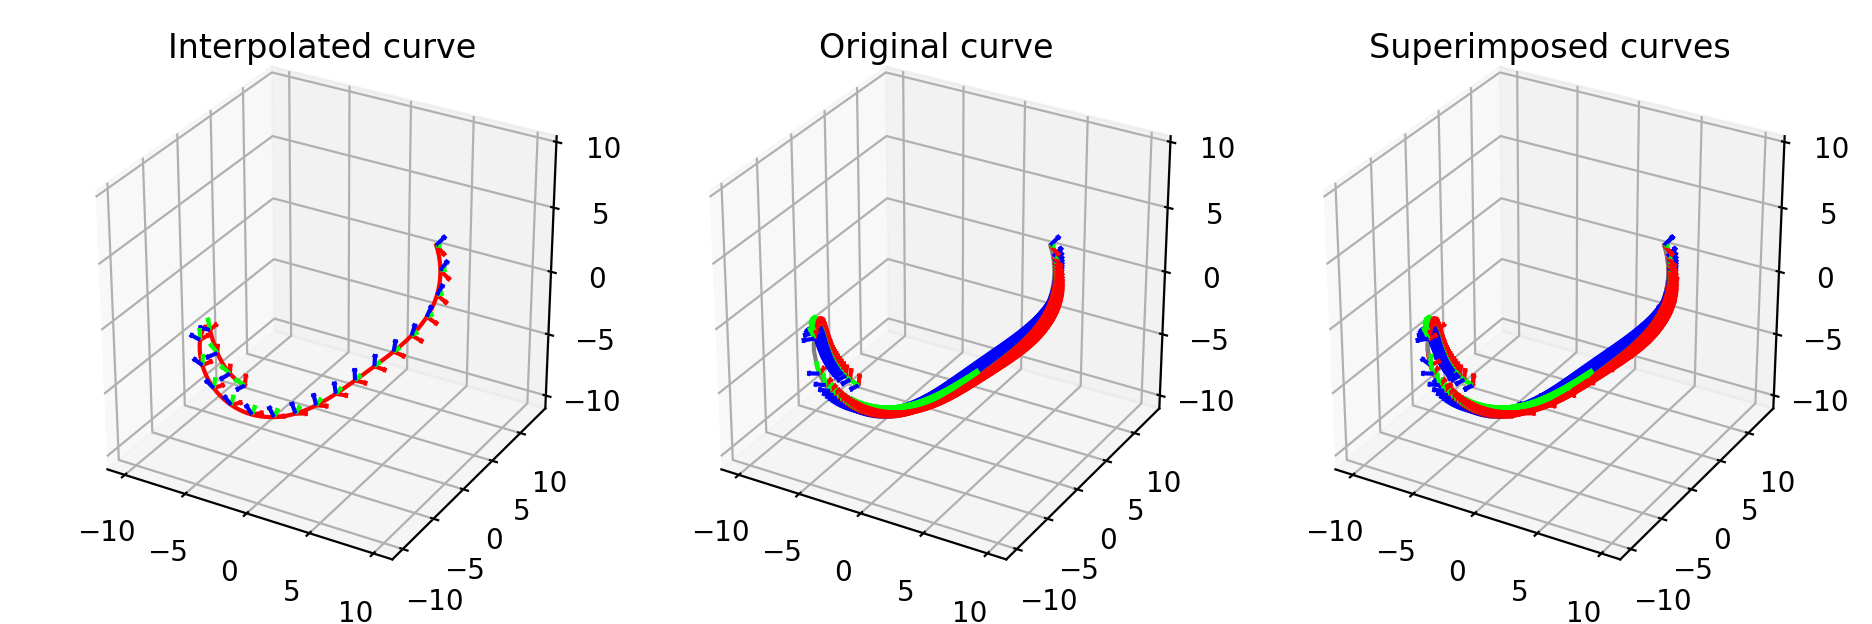

[[-0.03292835  8.20375661  8.9264998 ]
 [ 6.17980534 -6.12468128  5.27346647]
 [-2.86982133 -1.35264417  1.17641101]
 [-8.53513131  4.98319458 -6.32314111]
 [ 1.81982911 -9.21631027 -0.0410237 ]
 [ 0.356912   -1.92997222  4.1015495 ]
 [ 9.88486021  8.69958172  1.17118069]
 [ 7.09703366 -0.41030909  5.13261402]
 [ 9.24807879 -5.36416777  9.90962117]
 [ 3.57882018 -2.07419503  9.24862809]
 [ 0.70134211  9.2774026  -7.68748242]]


In [85]:
# Visualize how well the fitted curve reflects original data
index=53 #53
Path=CplrPathList[index]
Orient=CplrOrientList[index]
Path_100, Orient_100 = normalizeMotion(Path, Orient)

fig = plt.figure(figsize=.65*plt.figaspect(1/3))
ax = fig.add_subplot(1, 3, 1, projection='3d')
plt.title("Interpolated curve")
plotMotion(Path_100, Orient_100, ax, 10, color='r')
ax = fig.add_subplot(1, 3, 2, projection='3d')
plt.title("Original curve")
plotMotion(Path, Orient, ax, 10, color='grey')
ax = fig.add_subplot(1, 3, 3, projection='3d')
plt.title("Superimposed curves")
plotMotion(Path_100, Orient_100, ax, 10, color='r')
plotMotion(Path, Orient, ax, 10, color='grey')

print(MechList[index])

<IPython.core.display.Javascript object>


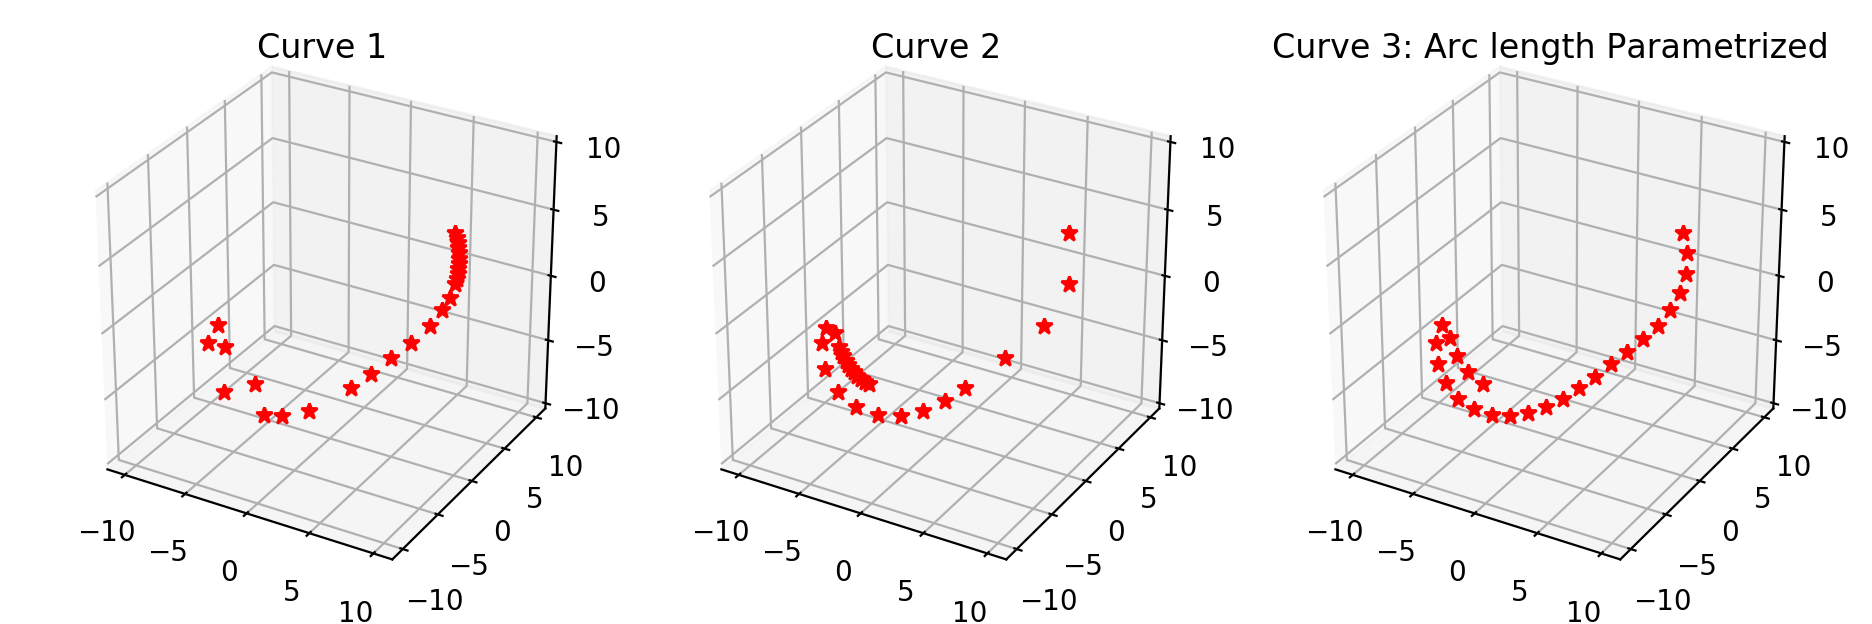

In [22]:
# Visualize different parametrizations
index=53
Path=CplrPathList[index]

xp=Path[:,0]
yp=Path[:,1]
zp=Path[:,2]
# Check for duplicate points as interpolation routine errors out
okay = np.where(np.abs(np.diff(xp)) + np.abs(np.diff(yp)) + np.abs(np.diff(zp)) > 0)
xp = np.r_[xp[okay], xp[-1]]
yp = np.r_[yp[okay], yp[-1]]
zp = np.r_[zp[okay], zp[-1]]

# Fit cubic B-spline to the data points
num_pts=26
tck, u =interpolate.splprep([xp,yp,zp],s=.01)
u_g1=[0,.01,.02,.03,.04,.05,.06,.07,.08,.09,.1,.13,.16,.2,.25,.3,.35,.4,.5,.56,.6,.7,.8,.85,.9,1]
x_1, y_1, z_1 = interpolate.splev(u_g1, tck)
Path_1 = np.vstack(([x_1],[y_1],[z_1])).T
u_g2=[1,.99,.98,.97,.96,.95,.94,.93,.92,.91,.9,.87,.83,.8,.75,.7,.65,.6,.55,.5,.45,.4,.3,.2,.1,0]
x_2, y_2, z_2 = interpolate.splev(u_g2, tck)
Path_2 = np.vstack(([x_2],[y_2],[z_2])).T
u_fine = np.linspace(0,1,num_pts)
x_3, y_3, z_3 = interpolate.splev(u_fine, tck)
Path_3 = np.vstack(([x_3],[y_3],[z_3])).T

fig = plt.figure(figsize=.65*plt.figaspect(1/3))
ax = fig.add_subplot(1, 3, 1, projection='3d')
plt.title("Curve 1")
plotPath(Path_1, ax, 10, color='r*')
ax = fig.add_subplot(1, 3, 2, projection='3d')
plt.title("Curve 2")
plotPath(Path_2, ax, 10, color='r*')
ax = fig.add_subplot(1, 3, 3, projection='3d')
plt.title("Curve 3: Arc length Parametrized")
plotPath(Path_3, ax, 10, color='r*')

In [23]:
MechList100=MechList;
CplrPathList100=[];

for i in range(len(CplrPathList)):
    Path=CplrPathList[i]
    Path_100=normalizePathPts(Path)
    CplrPathList100.append(Path_100)

# Normalize Data (Translation,Rotation, Scaling)

- Translation: Average of all points moved to origin.
- Rotation: Principal axes rotated to align with x-axis
- Scaling: All curves are divided by arclength and normalized to unit length (sideaffect: max range is -.5 to .5)
- Parametrization Direction: Start point of the open curve is selected to have larger x-coordinate

In [24]:
# Calculate the total arc length of a 3D curve
def calcArcLen(path):
    ArcLen=0
    for j in range(0,len(path)-1):
        d=LA.norm(path[j]-path[j+1])
        ArcLen+=d
    return ArcLen

def normalizePath(Path):
    #TRANSLATION
    T=np.mean(Path,axis=0)
    Trans_Path=Path-T

    #ROTATION
    Covariance_Mat=np.cov(Trans_Path,rowvar=0)
    sing_vec=LA.svd(Covariance_Mat)[0]
    R=sing_vec.T
    Rot_Path=np.matmul(R,Trans_Path.T).T
    
    #SCALING
    #S=np.max(np.std(Rot_Path,axis=0)) # Scale according to max st dev
    #S=np.max(np.abs(Rot_Path)) # Scale largest dim to 1/-1 bound
    S=calcArcLen(Rot_Path)
    Scale_Path=Rot_Path/S
    
    #DIRECTION
    if Scale_Path[0,0]<Scale_Path[0,-1]:
        norm_Path=np.flipud(Scale_Path)
    else:
        norm_Path=Scale_Path

    return norm_Path, T, R, S

def normalizeMech(Mech, Translate, Rotate, Scale):
    Trans_Mech=Mech-Translate
    Rot_Mech=np.matmul(Rotate,Trans_Mech.T).T
    Scale_Mech=Rot_Mech/Scale
    return Scale_Mech

In [25]:
Norm100MechList=[];
Norm100CplrPathList=[];

for i in range(len(CplrPathList)):
    Path=CplrPathList100[i]
    Mech=MechList100[i]
    
    nPath, T, R, S=normalizePath(Path)
    nMech=normalizeMech(Mech, T, R, S)
    
    Norm100MechList.append(nMech)
    Norm100CplrPathList.append(nPath)

print(np.array(MechList).shape)
print(np.array(CplrPathList).shape)

(7408,)
(7408,)


<IPython.core.display.Javascript object>


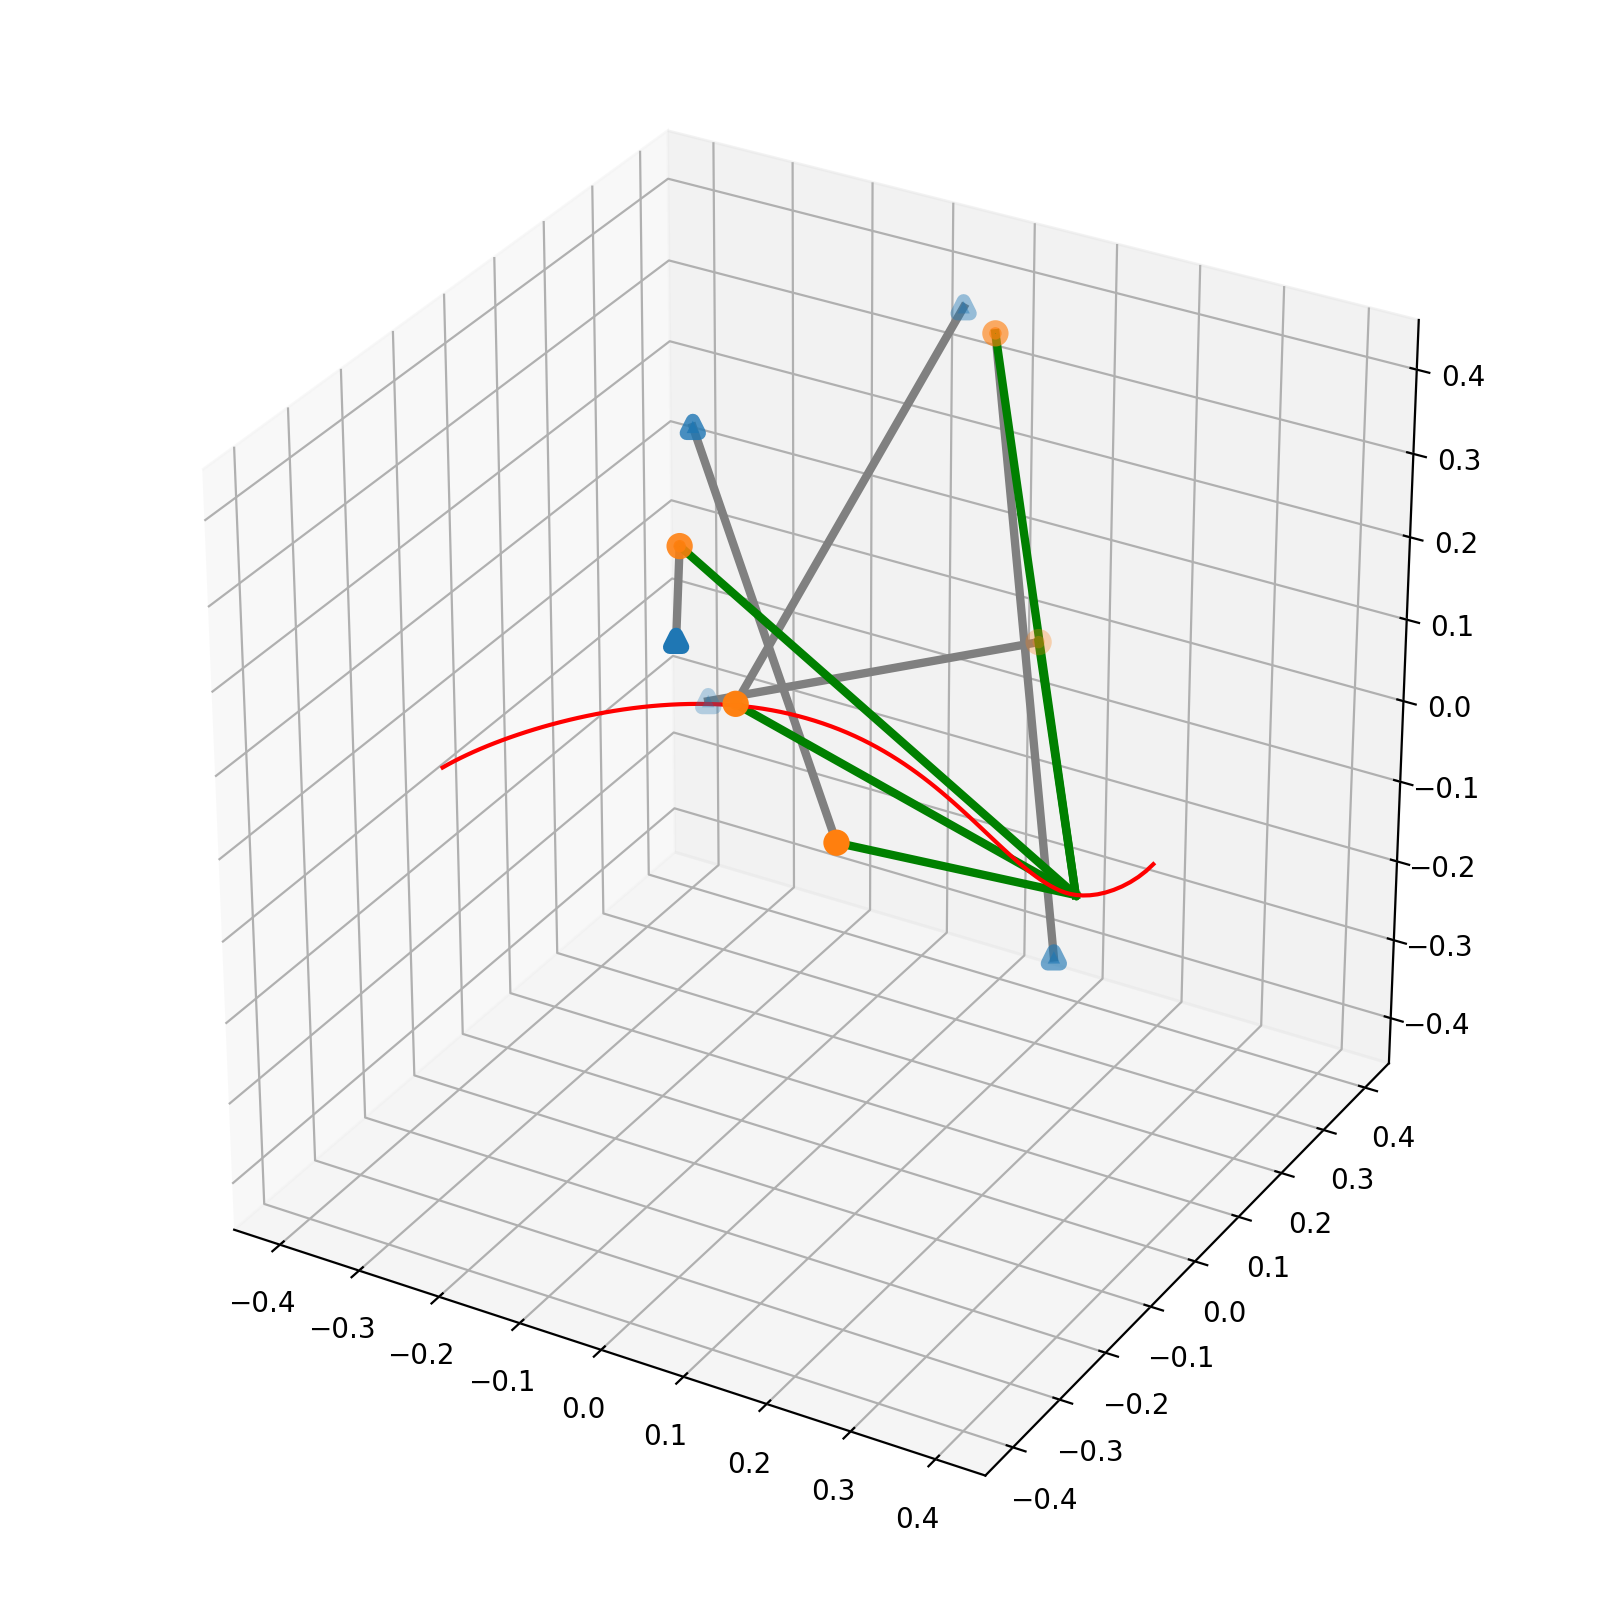

In [31]:
fig= plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection='3d')
plotMech5SS(Norm100MechList[0],ax)
plotPath(Norm100CplrPathList[0], ax, .4,'r' )

<IPython.core.display.Javascript object>


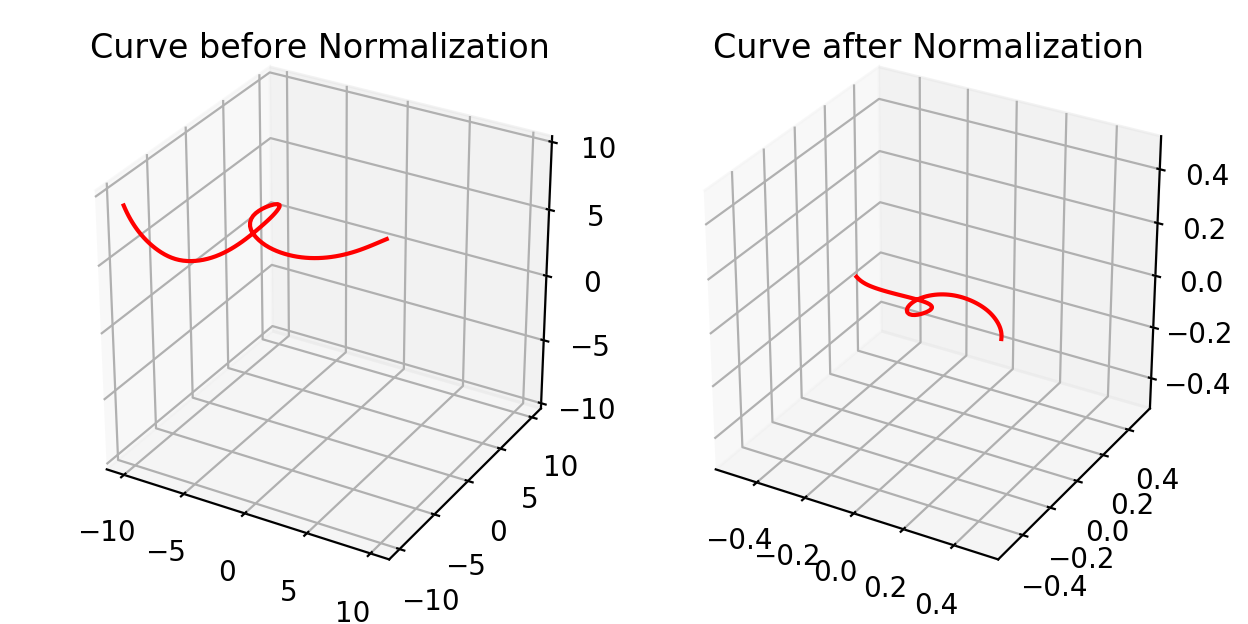

In [26]:
i=8
Path_1=CplrPathList100[i]
Path_2=Norm100CplrPathList[i]
fig = plt.figure(figsize=.65*plt.figaspect(1/2))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plt.title("Curve before Normalization")
plotPath(Path_1, ax, 10, color='r')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plt.title("Curve after Normalization")
plotPath(Path_2, ax, .5, color='r')

<IPython.core.display.Javascript object>


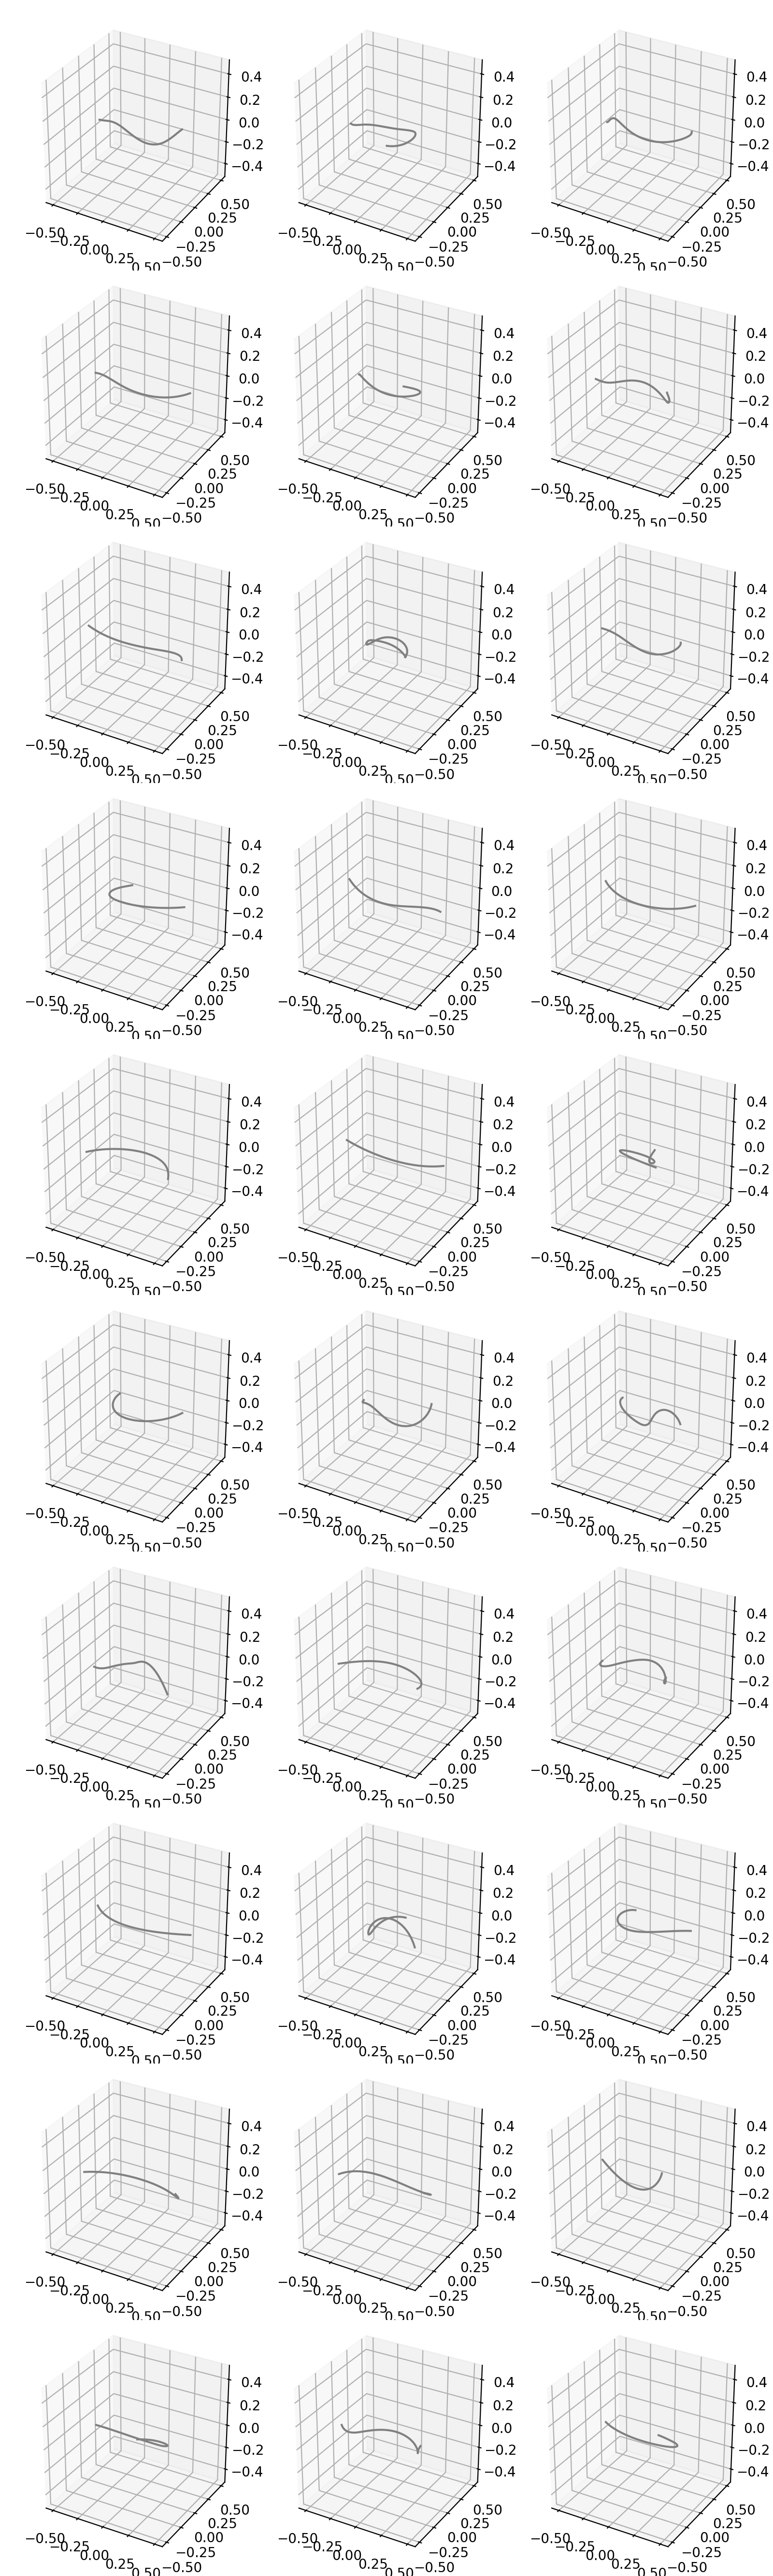

In [32]:
visualizePathsRand(np.array(Norm100CplrPathList))

# Normalize coordinates in x, y, z axis independently (NOT USED)

Due to our path normalization technique, we orient maximum variance direction with x axis and minimum variance in z axis. This bias leads to the VAE learning X and Y axis data predominanity. Due to this each axis data need to be scaled independently for better fit. However, the aspect ration of the path is not conserved due to this operation and the paths we get are not coupler paths. Thus we ignore this operation

In [18]:
def scalePath(Path):
    S=np.std(Path,axis=0)
    Scale_Path=[]
    Scale_Path.append(Path[:,0]/S[0])
    Scale_Path.append(Path[:,1]/S[1])
    Scale_Path.append(Path[:,2]/S[2])
    return np.asarray(Scale_Path).T

Skewed100CplrPathList=[];
for i in range(len(Norm100CplrPathList)):
    spath=Norm100CplrPathList[i]
    Skewed100CplrPathList.append(scalePath(spath))

<IPython.core.display.Javascript object>


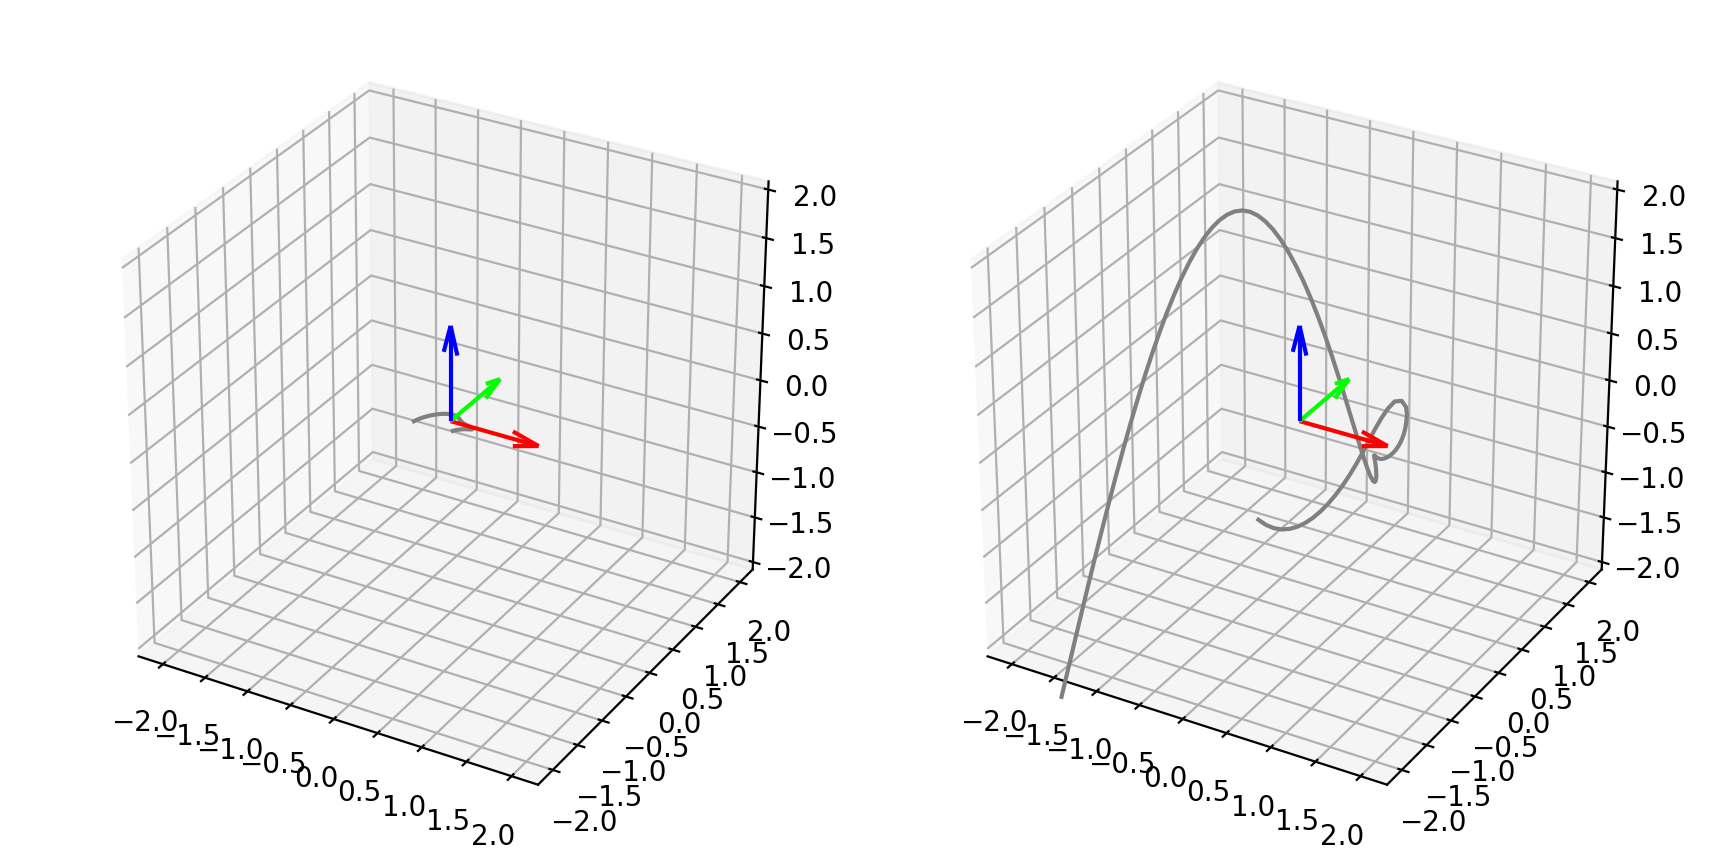

In [19]:
nPath=Norm100CplrPathList[21]
sPath=Skewed100CplrPathList[21]

fig = plt.figure(figsize=.9*plt.figaspect(1/2))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plotPath(nPath, ax, 2)
plotXYZ(np.zeros((1, 3)), np.identity(3), ax)
ax = fig.add_subplot(1, 2, 2, projection='3d')
plotPath(sPath, ax, 2)
plotXYZ(np.zeros((1, 3)), np.identity(3), ax)

# Store the Normalized Database

In [33]:
np.savez_compressed('db1_5SS_norm_s7408', cplrData=np.array(Norm100CplrPathList), mechData=np.array(Norm100MechList))

In [34]:
db = np.load('db1_5SS_norm_s7408.npz')
print(db.files)
print(db['cplrData'].shape)
print(db['mechData'].shape)

['cplrData', 'mechData']
(7408, 100, 3)
(7408, 11, 3)
